# EDA

In [ ]:
# Import required libraries

from typing import dataclass_transform
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import zipfile

# Upload and unzip the dataset
zip_path = "archive.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("archive")
print(" Files extracted successfully")

# Define data directories
base_dir = "archive/afhq"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")


 Files extracted successfully


In [ ]:
# List class names
categories = os.listdir(train_dir)
print("Classes:", categories)


Classes: ['cat', 'dog', 'wild']


In [ ]:
# Count images per class
for category in categories:
    train_count = len(os.listdir(os.path.join(train_dir, category)))
    val_count = len(os.listdir(os.path.join(val_dir, category)))
    print(f"{category} → Train: {train_count}, Val: {val_count}")


cat → Train: 5153, Val: 500
dog → Train: 4739, Val: 500
wild → Train: 4738, Val: 500


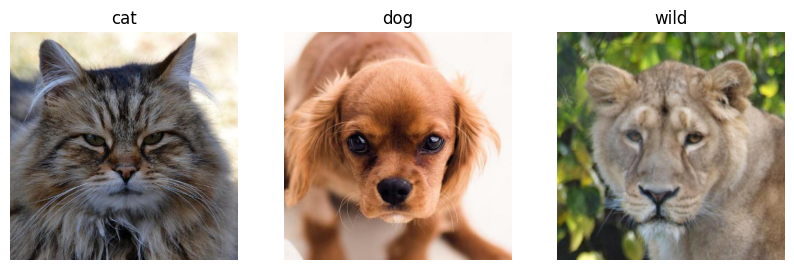

In [ ]:
#  Display one sample image from each class

plt.figure(figsize=(10, 4))

for i, category in enumerate(categories):
    path = os.path.join(train_dir, category)
    img_name = os.listdir(path)[0]
    img_path = os.path.join(path, img_name)
    img = Image.open(img_path)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")

plt.show()

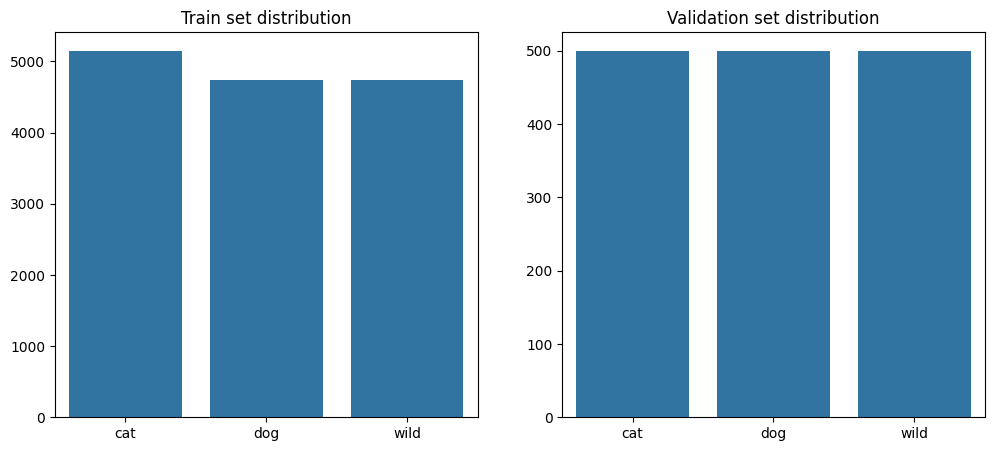

In [ ]:
# Visualize dataset distribution

train_counts = [len(os.listdir(os.path.join(train_dir, c))) for c in categories]
val_counts = [len(os.listdir(os.path.join(val_dir, c))) for c in categories]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=categories, y=train_counts, ax=ax[0])
sns.barplot(x=categories, y=val_counts, ax=ax[1])
ax[0].set_title("Train set distribution")
ax[1].set_title("Validation set distribution")
plt.show()

Average width: 512.0
Average height: 512.0


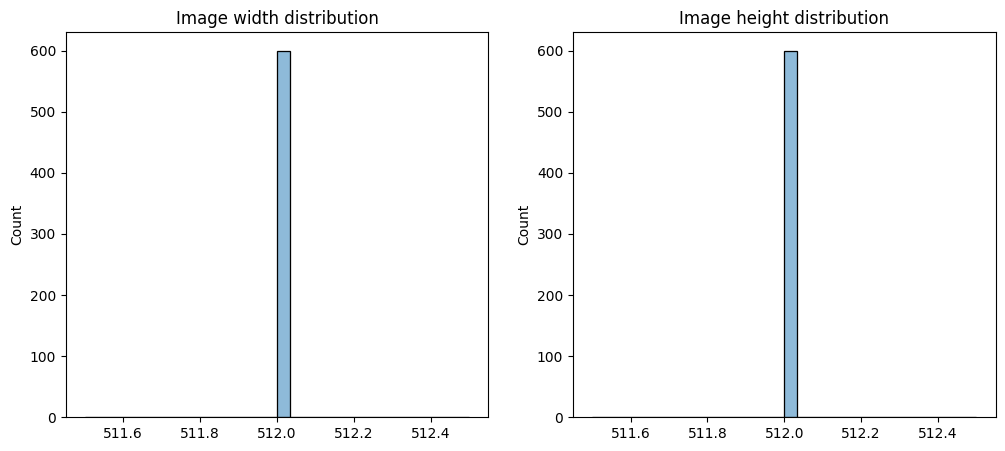

In [ ]:
# Check image dimensions (width & height)

# Collect image sizes from a small sample (to save time)

widths, heights = [], []

for category in categories:
    path = os.path.join(train_dir, category)
    for img_name in os.listdir(path)[:200]:  # only first 200 images per class
        img = Image.open(os.path.join(path, img_name))
        widths.append(img.size[0])
        heights.append(img.size[1])

print("Average width:", np.mean(widths))
print("Average height:", np.mean(heights))

# Plot width and height distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(widths, bins=30, ax=ax[0], kde=True)
sns.histplot(heights, bins=30, ax=ax[1], kde=True)
ax[0].set_title("Image width distribution")
ax[1].set_title("Image height distribution")
plt.show()


In [ ]:
# train/Validation Split
# Import libraries

import shutil
import random

# Define paths
new_train_dir = os.path.join(base_dir, "train_new")
new_val_dir = os.path.join(base_dir, "val_new")

# Create new folders if not exist
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_val_dir, exist_ok=True)

categories = os.listdir(train_dir)


# Split each class

split_ratio = 0.8  # 80% train, 20% new validation

for category in categories:
    class_path = os.path.join(train_dir, category)
    images = os.listdir(class_path)
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)
    train_imgs = images[:split_index]
    val_imgs = images[split_index:]

    # Create category folders in new split directories
    os.makedirs(os.path.join(new_train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(new_val_dir, category), exist_ok=True)

    # Copy images to train_new
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_train_dir, category))

    # Copy images to val_new
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_val_dir, category))

print("Train/Validation split done")


Train/Validation split done


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adding rescale to normalize the data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create Generators
train_generator = train_datagen.flow_from_directory(
    'archive/afhq/train_new',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'archive/afhq/val_new',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

print('Data generators created successfully with Normalization!')

Found 11703 images belonging to 3 classes.
Found 2927 images belonging to 3 classes.
Data generators created successfully with Normalization!


# Modeling

In [ ]:
# Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# (Input Layer)
inputs = Input(shape=(128, 128, 3))

# Building Layers (Feature Extraction)
# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Block 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Block 3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Block 4
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# (Classification Head)
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()
print('Custom Functional API Model built successfully')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,899 (1.74 MB)

 Trainable params: 455,939 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

Custom Functional API Model built successfully


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping Settings
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_animal_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Training
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5880 - loss: 0.9217
Epoch 1: val_loss improved from inf to 1.33664, saving model to best_animal_model.keras
366/366 ━━━━━━━━━━━━━━━━━━━━ 875s 2s/step - accuracy: 0.5882 - loss: 0.9212 - val_accuracy: 0.4698 - val_loss: 1.3366
Epoch 2/25
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8129 - loss: 0.4609
Epoch 2: val_loss did not improve from 1.33664
366/366 ━━━━━━━━━━━━━━━━━━━━ 883s 2s/step - accuracy: 0.8130 - loss: 0.4607 - val_accuracy: 0.4780 - val_loss: 2.6718
Epoch 3/25
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8997 - loss: 0.2678
Epoch 3: val_loss improved from 1.33664 to 0.60641, saving model to best_animal_model.keras
366/366 ━━━━━━━━━━━━━━━━━━━━ 869s 2s/step - accuracy: 0.8998 - loss: 0.2677 - val_accuracy: 0.7954 - val_loss: 0.6064
Epoch 4/25
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9348 - loss: 0.1693
Epoch 4: val_loss improved from 0.60641 to 0.26956, saving model to best_animal

In [ ]:
# Testing

from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'archive/afhq/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Found 1500 images belonging to 3 classes.
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 517ms/step - accuracy: 0.9903 - loss: 0.0486
Test Loss: 0.0613
Test Accuracy: 0.9847


In [ ]:
# Submission

test_generator.reset()

# Predections
filenames = test_generator.filenames
preds = model.predict(test_generator)
pred_classes = np.argmax(preds, axis=1)

# Classeds Names
labels = {v: k for k, v in train_generator.class_indices.items()}
pred_labels = [labels[k] for k in pred_classes]

# Create CSV file
submission = pd.DataFrame({
    'filename': filenames,
    'predicted_label': pred_labels
})

submission.to_csv('submission.csv', index=False)
print('Submission file created: submission.csv')
print(submission.head())


47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 521ms/step
Submission file created: submission.csv
                    filename predicted_label
0  cat/flickr_cat_000008.jpg             cat
1  cat/flickr_cat_000011.jpg             cat
2  cat/flickr_cat_000016.jpg             cat
3  cat/flickr_cat_000056.jpg             cat
4  cat/flickr_cat_000076.jpg             cat


In [ ]:
# Save predictions in HDF5 format
submission.to_hdf('submission.h5', key='submission', format='table')
print(' Submission saved to submission.h5')

 Submission saved to submission.h5
